In [7]:
import os
from defillama2 import DefiLlama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [9]:
# set paths and create dirs 
base_dir = '../'
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [10]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ 
    Return a function for formatting matplot axis numbers human friendly. 

    Parameters
    ----------
    dollar : logical
        If True, will add $ in front of the numbers.
    decimals : int
        Number of decimals to display.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

def plot_tvl_apy(df, tvl_col='tvlUsd', apy_col='apy', title=None):
    # plot TVL and APY over time to see their relationships. 
    
    # plot TVL on the left y-axis
    ax1 = df[tvl_col].plot()
    dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
    ax1.yaxis.set_major_formatter(dollar_formatter)
    for tl in ax1.get_yticklabels():
        tl.set_color('#008FD5')
    ax1.set_ylabel('TVL ($USD)', color='#008FD5')

    # plot APY on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[apy_col], color='#77AB43')
    ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
    for tl in ax2.get_yticklabels():
        tl.set_color('#77AB43')
    ax2.set_ylabel('APY', color='#77AB43')

    plt.title(title)
    plt.tight_layout()

## Get current APY and TVL of the UniV3 WBTC-WETH pools

There are two major UniV3 WBTC-WETH pools:

- [0.3%  fee](https://info.uniswap.org/#/pools/0xcbcdf9626bc03e24f779434178a73a0b4bad62ed)
- [0.05% fee](https://info.uniswap.org/#/pools/0x4585fe77225b41b697c938b018e2ac67ac5a20c0)

In [11]:
obj = DefiLlama()

In [12]:
df = obj.get_pools_yields()

In [17]:
# only get univ3 wbtc-weth pools
is_true = (
    df.chain.isin(['Ethereum']) &
    df.project.isin(['uniswap-v3']) &
    df.symbol.isin(['WBTC-WETH']) 
)
cols = ['chain', 'symbol', 'pool', 'tvlUsd', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
subdf = df.loc[is_true, cols].sort_values('apy', ascending=False)

# tell which pool charges 0.05%, 0.3% or 1% fees
conds = [(subdf.pool == 'd59a5728-d391-4989-86f6-a94e11e0eb3b'),
         (subdf.pool == 'c5599b3a-ea73-4017-a867-72eb971301d1'),
         (subdf.pool == 'd12f85a6-6684-4b8e-82bd-f47d3a052ace')]
choices = ['0.05%', '0.3%', '1%']
subdf['pool_fee'] = np.select(conds, choices)
cols = ['chain', 'symbol', 'pool', 'pool_fee', 'tvlUsd', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
subdf[cols]

,chain,symbol,pool,pool_fee,tvlUsd,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
113,Ethereum,WBTC-WETH,d59a5728-d391-4989-86f6-a94e11e0eb3b,0.05%,55398798,25.5685,16.5333,21.2359,0.7249,232,Down,87.0000
47,Ethereum,WBTC-WETH,c5599b3a-ea73-4017-a867-72eb971301d1,0.3%,178661604,11.0068,1.3008,14.8370,0.5781,232,Down,52.0000
5368,Ethereum,WBTC-WETH,d12f85a6-6684-4b8e-82bd-f47d3a052ace,1%,97224,3.8455,-7.7955,7.0863,0.6787,232,Down,56.0000


Observations:

- The 0.05%-fee-pool has a TVL less than 1/3 of the 0.3%-fee-pool.
- The 0.05%-fee-pool has a APY more than twice of the 0.3%-fee-pool. For the last 7 days, the APY of the 0.3%-fee-pool is meager. DefiLlama predicts the APY of both pools to drop. 
- Historically, over 232 days, the average APY for the 0.05%-fee-pool is 21.24% with a 0.7% volatility, and the average APY for the 0.3%-fee-pool is 14.84% with a 0.58% volatility.

## Get historical APY and TVL of the UniV3 WBTC-WETH pools

In [18]:
pool_005_id = 'd59a5728-d391-4989-86f6-a94e11e0eb3b'
pool_03_id  = 'c5599b3a-ea73-4017-a867-72eb971301d1'

In [19]:
df005 = obj.get_pool_hist_apy(pool_005_id).loc[:,['tvlUsd', 'apy']]
df03  = obj.get_pool_hist_apy(pool_03_id).loc[:,['tvlUsd', 'apy']]

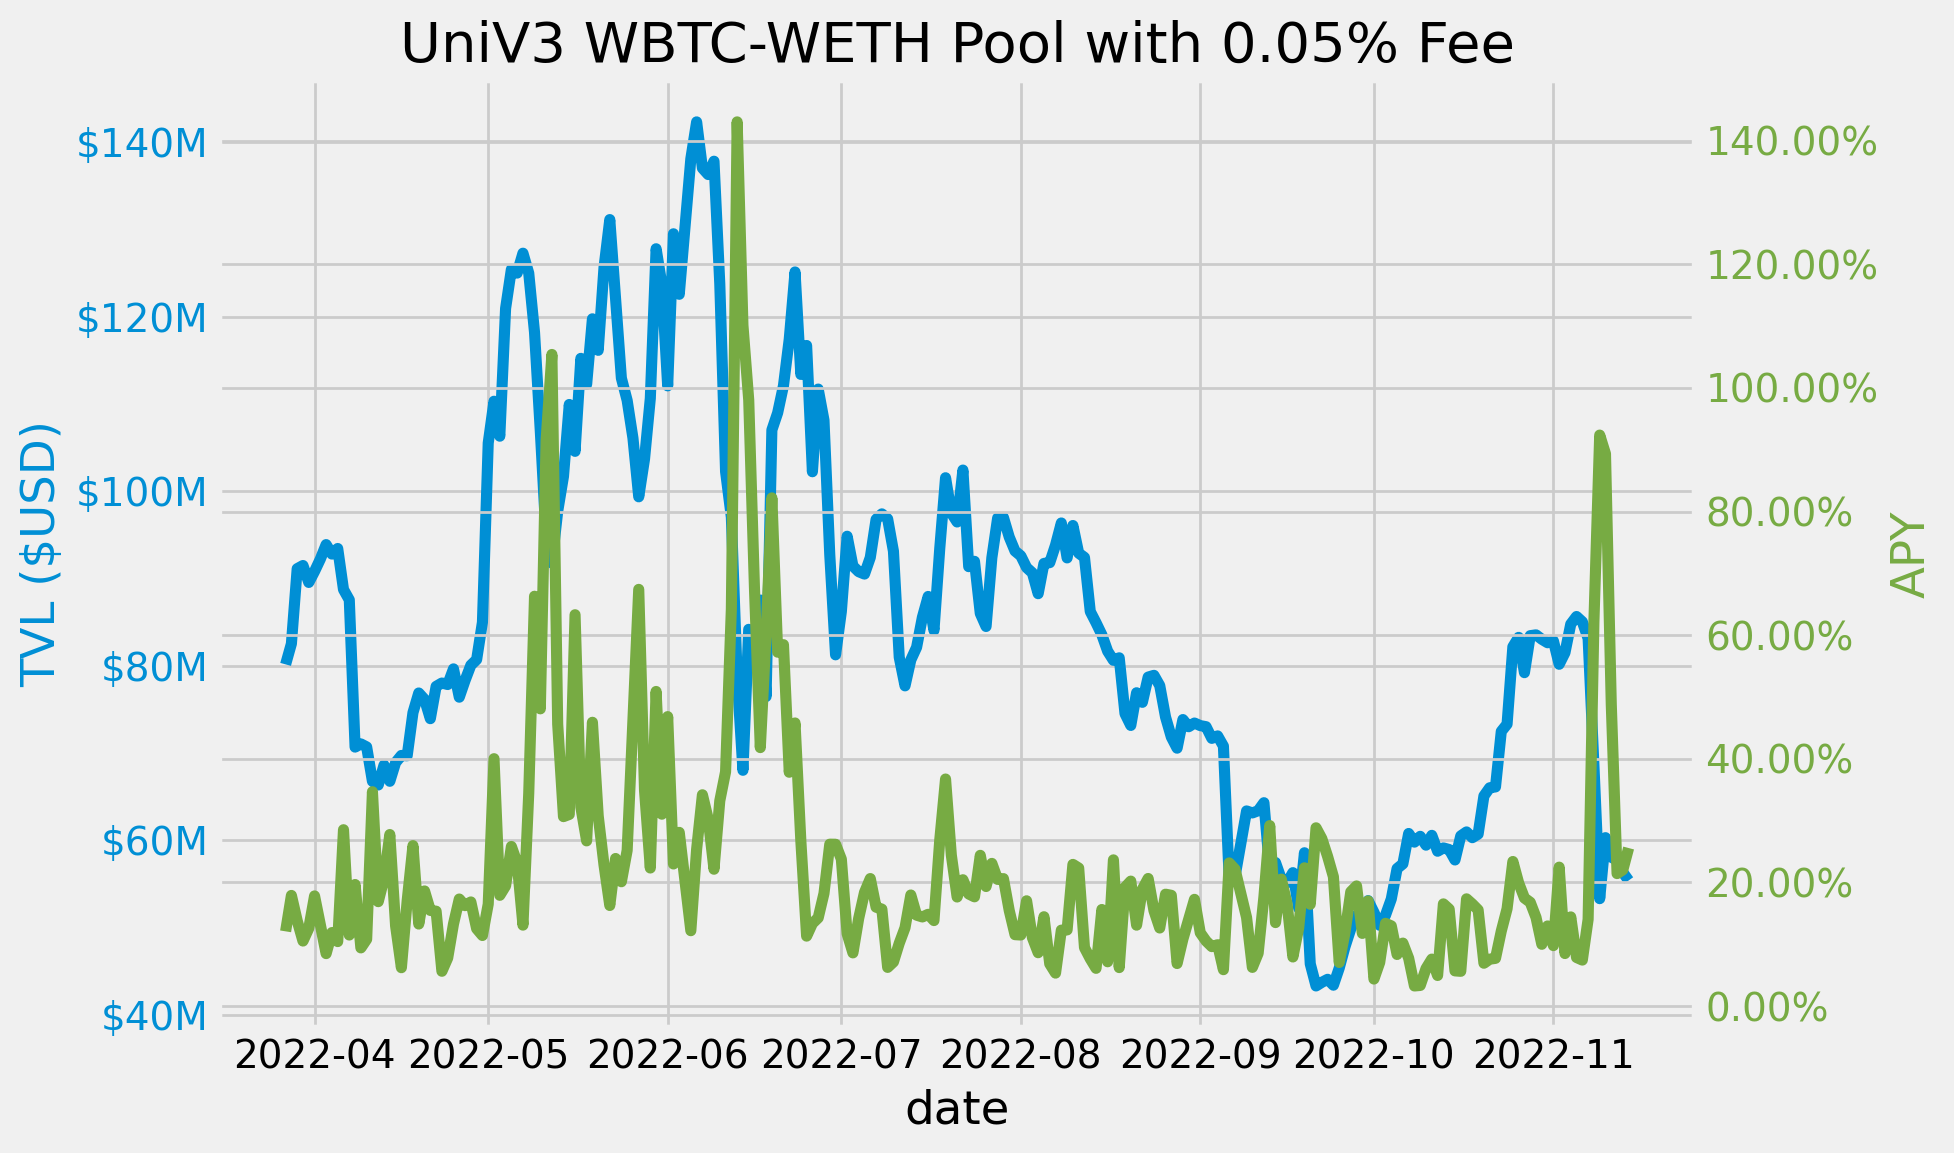

In [20]:
plot_tvl_apy(df005, title='UniV3 WBTC-WETH Pool with 0.05% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH Pool with 0.05% Fee.png'), dpi=300)

The TVL of the 0.05%-fee-pool has been increasing since late September and had a sharp in early and mid Nov due to FTX fiasco. As a result, the yield holds steady above 20%. 

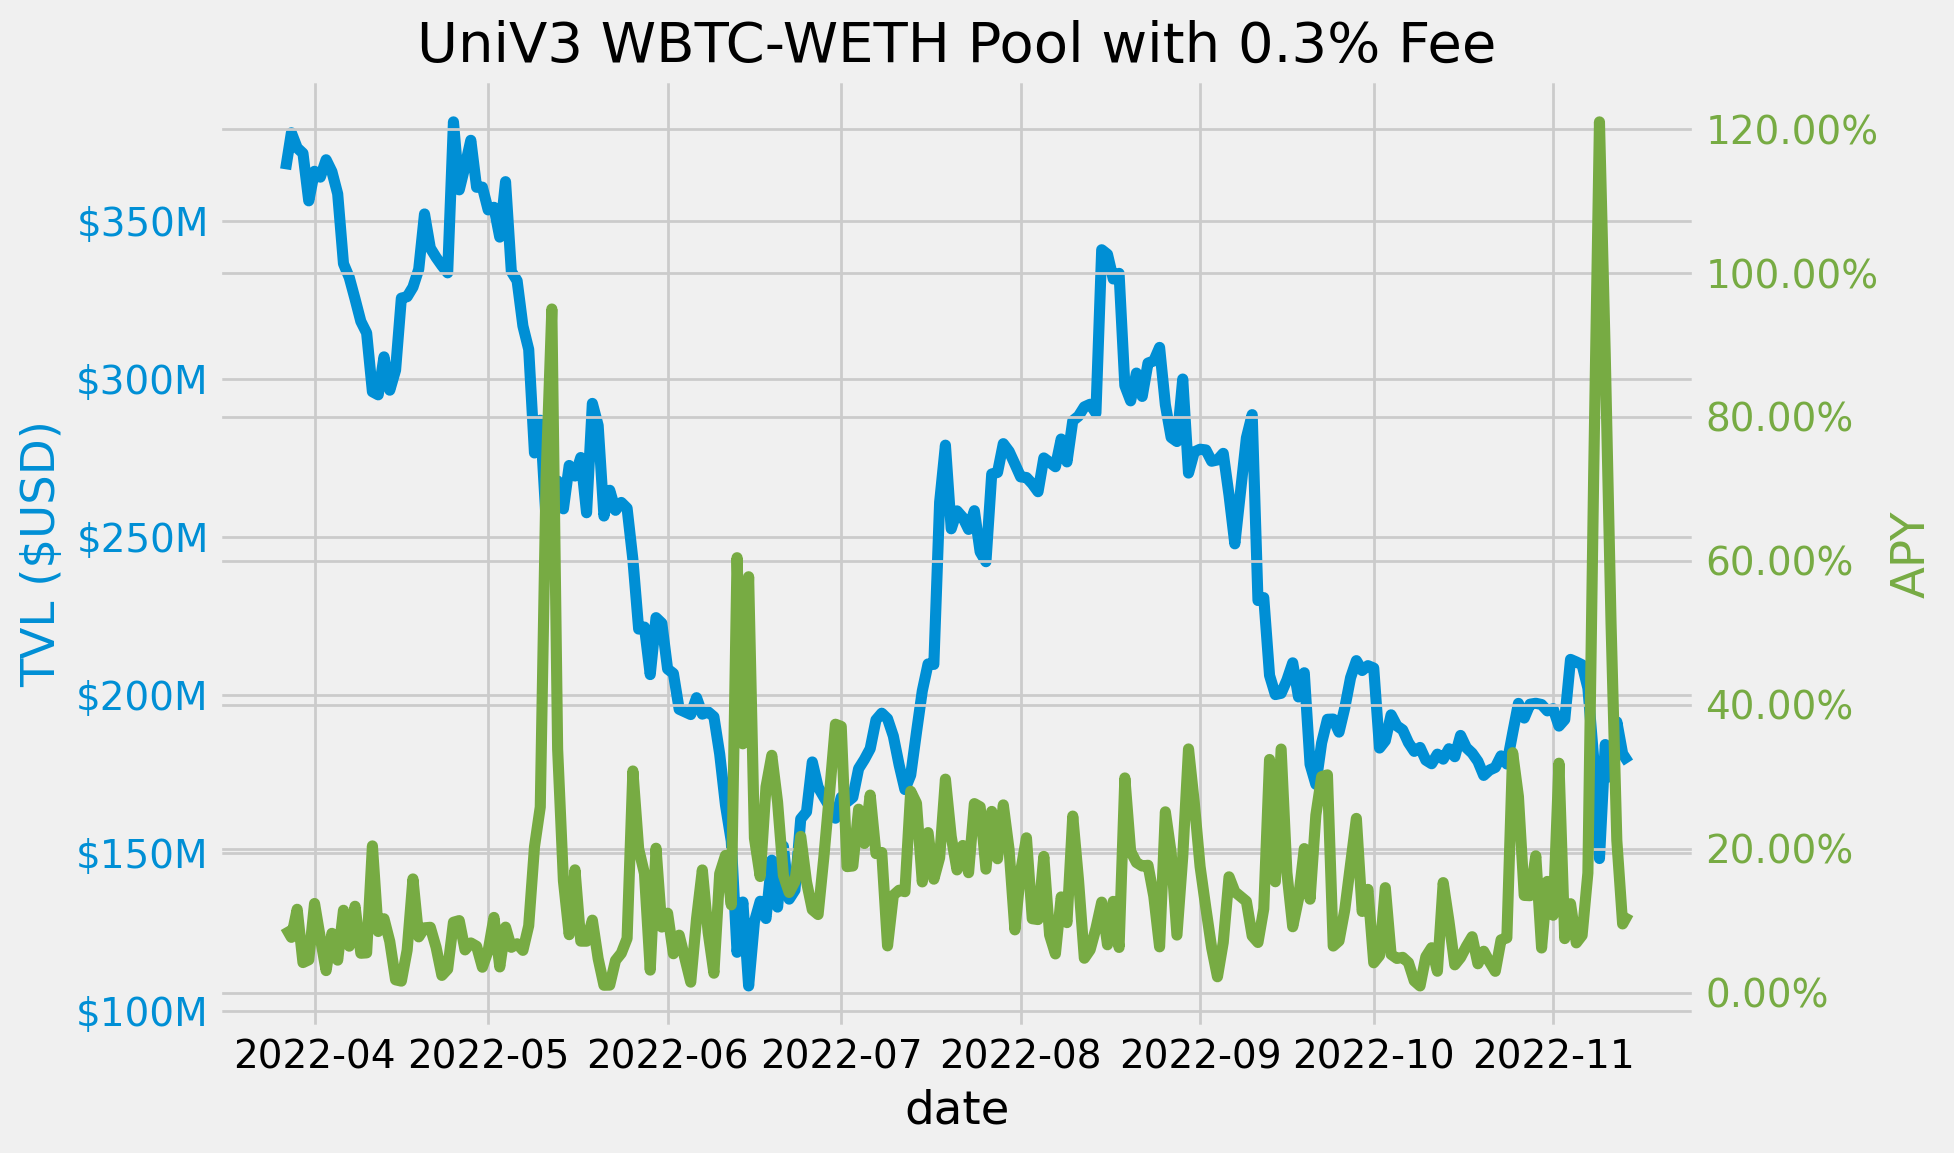

In [21]:
plot_tvl_apy(df03, title='UniV3 WBTC-WETH Pool with 0.3% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH Pool with 0.3% Fee.png'), dpi=300)

The TVL of the 0.3%-fee-pool had a big drop in September and another drop in early Nov due to FTX fiasco. Its yield spiked during the week of FTX blowup but now back down below 20%.

In [22]:
# how many days in the past the 0.05%-fee-pool has APY > the 0.3%-fee-pool?
dat = pd.merge(df005, df03, left_index=True, right_index=True)
dat.columns = ['TVL005', 'APY005', 'TVL03', 'APY03']
(dat.APY005 > dat.APY03).sum()

160

In [23]:
(dat.APY005 > dat.APY03).sum() / len(dat)

0.6926406926406926